## Example: sine waves with periodicity
#### Section 4.2 of the paper

$$
\boldsymbol{\mathcal{V}} \in \mathbb{R}^2, \boldsymbol{\mathcal{Y}} \in \mathbb{R}, \mathbf{F}: \mathbb{R}^2 \to \mathbb{R} \ .
$$

$$
y = \sin{k x}, k \in [1,3], \ x\in [-\pi, \ \pi], \quad  \boldsymbol{v} = [k,x]^T \ .
$$

Unlike the other case, we include periodicity of the sine waves in the current example such that the non-identifiable manifold of $\boldsymbol{\mathcal{V}}$ is no longer $kx = const$.

In [1]:
# Note: Please initiate Jupyter Lab where this script is located
# Note: re-start the python kernel if some attribute of a class is not identified
# Note: there is an abuse of notation of x (X) and v. The x (X) in the code mostly means the v in the paper. For the current problem: v = [k,x]
# Note: the hyperparameters have been adjusted for faster execution within JupyterLab. 
#        For more precise results and improved efficiency, we recommend running the code locally with appropriately fine-tuned hyperparameters

import torch
import os
import math
import numpy as np
import sys
import time
import copy
from matplotlib import pyplot as plt
from PIL import Image
from pdf2image import convert_from_path
from Tools.Data_generation import * # Data generation
from Tools.DNN_tools import *       # Common tools in DNN modeling
from Tools.Training_tools import *  # Main trainer class of the inVAErt network and the training/testing algorithm
from Tools.plotter import *         # Common plotting tools 

### Basic setup: device, precision and folder creation 

For each case, remember to change the case label

In [2]:
# Basic setup
#--------------------------------------------------------------------------------------#
# determine if to use GPU, GPU is faster with large mini-batch
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# set tensor type to double
torch.set_default_dtype(torch.float64)

# path for saving the synthetic dataset
os.makedirs('Dataset/', exist_ok = True)   

# path for saving the trained neural network model 
os.makedirs('Model_save/', exist_ok = True)

# case label
prefix = 'sine_waves'
#--------------------------------------------------------------------------------------#


### Data generation, scaling and training/testing dataset split

For any case, we only need to define the dataset $\mathbf{X}$ and $\mathbf{Y}$. They can be synthetic data or solutions of ODE/PDEs.
$\mathbf{X}$ is the input tensor containing the $\boldsymbol{v}$ samples plus the auxiliary data $\mathcal{D}_{\boldsymbol{v}} \ $, if needed. $\mathbf{Y}$ is the output tensor containing the $\boldsymbol{y}$ samples.

In this example, we define uniform random samples of $k \sim \mathcal{U}([1,3])$, $x \sim \mathcal{U}([-\pi, \pi])$, and forward the linear system 10000 times to gather the training data.

In [3]:
# Data generation
# X: input tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(V) or dim(V) + dim(D_v), i.e. if auxiliary data is used, see Section 2.1
# Y: output tensor of the inVAErt network, size: number of sample x number of feature
#    number of feature = dim(Y)
#-------------------------------------------------------------------------#
# If True, save the generated data, If False, load the generated data. 
Saving      = True                     

# If True, scale the data, use z-std method (c.f. Appendix of the paper)
Scaling     = True

# Define datasize and ranges
Sample_size = 10000                 # how many samples needed
k           = [1,3]         		# frequency
x           = [-np.pi, np.pi]       # input

# generate or load the data
if Saving == True:
	# call data generator function and save the data
	X,Y =  Data_sine_waves(Sample_size, k, x, Saving)
    
    # load the generated data from file
else:
	X   = np.loadtxt('Dataset/' + prefix + '_X.csv', delimiter = ',', ndmin=2) 
	Y   = np.loadtxt('Dataset/' + prefix + '_Y.csv', delimiter = ',', ndmin=2) #ndmin = 2 means: always keep array dimension = 2

# backup for later plotting
Y_plot = copy.deepcopy(Y)
V_plot = copy.deepcopy(X)

# Data-normalization if needed
if Scaling == True:
    # call z-standardization 
	scaler = Zscaling()
	X, muX, stdX = scaler.z_std(X) # apply transformation, record the mu and std
	Y, muY, stdY = scaler.z_std(Y) # apply transformation, record the mu and std
    
# convert to pytorch tensors from numpy array
X = torch.from_numpy(X).to(device)
Y = torch.from_numpy(Y).to(device)

# Training-Testing-Dataset-Split
T_portion = 0.75 # 75% for training, the rest for testing
train_tensor, train_truth_tensor, test_tensor, test_truth_tensor = \
									TT_split(Sample_size, T_portion, X, Y)

print('data-generation is done...')
#-------------------------------------------------------------------------#

Data generation: 2000/10000
Data generation: 4000/10000
Data generation: 6000/10000
Data generation: 8000/10000
Data generation: 10000/10000
data-generation is done...


### Define hyperparamters, initiate trainer class and define each component of the inVAErt network

For the current setup, we define the emulator $\mathscr{N}_e \ $, the Real-NVP based normalizing flow model $\mathscr{N}_f$ and the variational decoder (VAE + decoder) $\mathscr{N}_v$ + $\mathscr{N}_d$ as three separate modules and train them independently. This allows us always use the exact label instead of network predictions. However, for stochastic extension of our inVAErt network, we need to trained them altogether. For more details, please see the appendix and Section 2.4 of the paper.

In [4]:
# Define hyperparameters, initiate trainer and define models 
#-------------------------------------------------------------------------------#
# init folder
folder_name = 'Model_save/'+ prefix 
os.makedirs(folder_name, exist_ok = True) # warning: be careful the overwrite here
# if scaled, save the scaling constants
if Scaling == True:
    scaler.save_scaling_constants(folder_name, muX, muY, stdX, stdY)

# Define hyperparameters, see, e.g. appendix of the paper
# Note: grid search for more optimal parameters TBD
para_dim    =   X.shape[1]              # dim(V). In this case, we do not have auxillary data
nB          =   [128,128,128]           # mini-batch size of N_e, N_f, N_v+N_d
learning_rate = [5e-3, 1e-3, 1e-2]      # initial learning rate for N_e, N_f, N_v+N_d
encoder_para  = [12,6,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for emulator N_e
nf_para       = [8,4,4, False]          # num_of_neuron, num_of_layer_of_each_block, num_of_affine_coupling_blocks, \
                                        # if_using_batch_norm for Real-NVP normalizing flow model N_f
vae_para      = [24,8,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for VAE N_v
decoder_para  = [36,8,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for decoder N_d
penalty       = [1, 200]                # penalty for KL div and decoder reconstruction loss, note: the encoder re-constraint loss L_r is not used here
lr_min        = [1e-4, 1e-4, 5e-5]      # minimal learning rate of N_e, N_f, N_v+N_d
decay         = [0.993, 0.99, 0.994]    # learning rate decay rate of N_e, N_f, N_v+N_d
weight_decay  = [0,0,0]                 # L2 regularization of N_e, N_f, N_v+N_d    
#--------------------------------------------------------------------------------#

# Initiate trainer class
Trainer = Training(X, Y, para_dim, train_tensor = train_tensor, train_truth_tensor = train_truth_tensor,\
									 test_tensor = test_tensor, test_truth_tensor = test_truth_tensor)

# Define models, i.e. N_e, N_f, N_v+N_d
Encoder_model, NF_model, Decoder_model = Trainer.Define_Models(device, encoder_para, nf_para, vae_para, decoder_para)

Number of trainable para for encoder is:673
y is a scalar, adding one aux dimension...
Number of trainable para for NF sampler is:1352
Number of trainable para for VAE+decoder is:11896


### Training and testing step of the emulator $\mathscr{N}_e$

Waiting time: < 1 min

In [5]:
#--------------------------------------------start to train each component of inVAErt--------------------------------------------------#
%matplotlib agg
# Training and testing step of the encoder, i.e. the emulator N_e
Trainer.Encoder_train_test(folder_name, Encoder_model, lr_min[0], learning_rate[0], decay[0], nB[0])
%matplotlib inline



---------------Start to train the encoder-----------------
Total number of epoches for training encoder is:556
Encoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, forward loss: 1.008e+00 , forward acc : -0.492745% , current lr: 5.000e-03
Testing: forward loss: 9.888e-01 , forward acc : 0.059491%
Training: Epoch: 200, forward loss: 4.862e-05 , forward acc : 99.995166% , current lr: 1.227e-03
Testing: forward loss: 7.931e-05 , forward acc : 99.991943%
Training: Epoch: 400, forward loss: 1.185e-05 , forward acc : 99.998811% , current lr: 3.011e-04
Testing: forward loss: 1.573e-05 , forward acc : 99.998400%


In [6]:
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
matplotlib.rcParams['figure.max_open_warning'] = 0  # turn off the warnings
# plotting specs
fs = 24
plt.rc('font',  family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text',  usetex=True)

### Verification of the emulator $\mathscr{N}_e$ 

We pick uniform random sample of the frequency parameter $k$ not belong to the training dataset and forward the trained emulator $\mathscr{N}_e \ $ with a sequence of $x$ values. From the following plot, we see the emulator prediction (NN) matches well with the truth (Trivial in the current case).

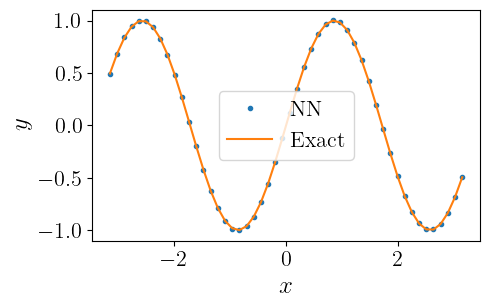

In [7]:
np.random.seed(121259) # pick a seed not belong to the training dataset, which is zero, you can play with this number
k_star      = np.random.uniform( k[0], k[1], 1).item() # pick a random k value in the range
sample_size = 50 # how many samples needed
x_star      = torch.linspace(x[0],x[1],sample_size) # take equal spaced x samples

# init emulator input
inputX  = torch.zeros(sample_size, 2)
inputX[:,0] = k_star
inputX[:,1] = x_star

# if using scaling during training, scale it forward
if Scaling == True:
	inputX = scaler.scale_it_forward(inputX, muX, stdX)

# Forward the trained emulator N_e
Encoder_model.eval()
with torch.no_grad():
	y_star = Encoder_model(inputX).detach().numpy()

# scale it back if scaled before
if Scaling == True:
	y_star = scaler.scale_it_back(y_star,muY,stdY)

# plot and check
plt.figure(figsize=(5, 3))
plt.plot(x_star, y_star, '.', label= 'NN')
plt.plot(x_star, np.sin( k_star * x_star  ), label = 'Exact')
plt.legend(fontsize=fs-8)
plt.xlabel('$x$', fontsize=fs-6)
plt.ylabel('$y$', fontsize=fs-6)
plt.tick_params(labelsize=fs-8)

### Training and testing step of the Real-NVP based normalizing flow model $\mathscr{N}_f$

Waiting time: < 1.5 min

Note: in this case, $\dim(y) = 1$, hence the affine coupling layer in Real-NVP model does not work. To solve this issue, we concatenate a random standard Gaussian variable to each training data of $y$. By the nature of Real-NVP normalizing flow model, the learning of the distribution of $y$ will not be affected.

In [8]:
# training and testing step of the Real-NVP based NF model
%matplotlib agg
Trainer.NF_train_test(folder_name, NF_model, lr_min[1], learning_rate[1], decay[1], nB[1])
%matplotlib inline



---------------Start to train the Real NVP-----------------
Total number of epoches for training NF is:229
NF: Total num of training batches:59, testing batches:20
Training: Epoch: 0, likelihood loss: 2.894e+00 , current lr: 1.000e-03
Testing: likelihood loss: 2.819e+00
Training: Epoch: 200, likelihood loss: 2.361e+00 , current lr: 1.340e-04
Testing: likelihood loss: 2.384e+00


### Verification of the Real-NVP based NF model $\mathscr{N}_f$ 

We pick random samples of $z$ from the base distribution of the NF model, i.e. standard normal distribution, and apply the trained NF transformations:  $z \to y$. The learned distribution of $y$ (NN) matches well with the distribution from the true data (Exact). Again, due to the simplicity of this problem, this task is still trivial.

Text(0.5, 1.0, 'Histogram of $y$')

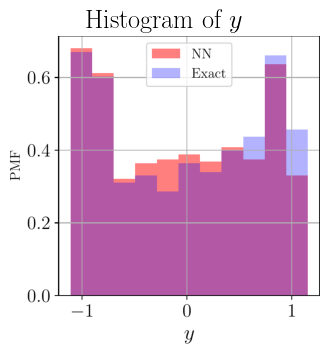

In [9]:
NF_Sample_size = 1000 # How many samples needed

# sample z from N(0,1) and transform back to y
Y_hat_samples = NF_model.sampling(NF_Sample_size, NF_model, seed_control= 542) # pick a random seed here

# Scale it back
# Note: as discussed before, the second component of Y_hat_samples is the concatenated random Gaussian RV, we can ignore it from now on
if Scaling == True:
	Y_hat_samples = scaler.scale_it_back(Y_hat_samples[:,0].reshape((-1,1)), muY[0].reshape((-1,1)), stdY[0].reshape((-1,1)))
else:
	Y_hat_samples = Y_hat_samples[:,0]

# where to save the figures
path     = folder_name + '/figures/NF'

#Save histogram and scatter correlation plots
%matplotlib agg
hist_plot(path, 'y', Y_hat_samples, '$y$', exact=Y_plot[:NF_Sample_size,0]) # histogram comparison for y
%matplotlib inline

# show figures
plt.figure(figsize=(4, 4))
im1 = convert_from_path(path + '/y.pdf')
plt.imshow(im1[0])
plt.axis('off')
plt.title('Histogram of $y$', fontsize = fs-5)

### Training and testing step of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$

Waiting time: < 3 min

In [10]:
# training and testing step of the VAE and decoder
%matplotlib agg
Trainer.Decoder_train_test(folder_name, Decoder_model, lr_min[2], learning_rate[2], decay[2], nB[2], penalty, l2_decay = weight_decay[2])
%matplotlib inline



---------------Start to train the variational decoder-----------------
Total number of epoches for training variational decoder is:880
VAEDecoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, inversion loss: 7.161e-01 , inversion acc : 27.417351% , KL : 2.942e+00 , current lr: 1.000e-02
Testing: inversion loss: 4.827e-01 , inversion acc : 53.497650% , KL : 3.987e+00
Training: Epoch: 200, inversion loss: 4.173e-02 , inversion acc : 95.764248% , KL : 3.829e+00 , current lr: 3.001e-03
Testing: inversion loss: 4.959e-02 , inversion acc : 95.216922% , KL : 3.909e+00
Training: Epoch: 400, inversion loss: 2.318e-02 , inversion acc : 97.644866% , KL : 4.044e+00 , current lr: 9.006e-04
Testing: inversion loss: 2.029e-02 , inversion acc : 98.040873% , KL : 4.050e+00
Training: Epoch: 600, inversion loss: 2.113e-02 , inversion acc : 97.860058% , KL : 4.107e+00 , current lr: 2.703e-04
Testing: inversion loss: 2.039e-02 , inversion acc : 98.030762% , KL : 4.131e+00
Trai

### Verification of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$   

#### Task1: non-identifiability analysis

In this task, we fix a $y^*$ sampled from the previously trained NF model $\mathscr{N}_f$ and sample $N$ latent variables $w$ from the latent space, which is the standard Gaussian distribution. This will give us $N$ values of $\tilde{\boldsymbol{y}}^* = [y^*, w]^T$ that correpond to the same $y^*$ and different values of $w \sim \mathcal{N}(0,1)$. 

Then, we apply the trained decoder $\mathscr{N}_d$ for model inversion, which predicts the system inputs $\widehat{\boldsymbol{v}}$ that should live on the non-identifiable subspace of $\boldsymbol{\mathcal{V}}$. 

In [11]:
# sample one y^* from the trained NF 
y_fix  =  NF_model.sampling(1, NF_model, seed_control= 18391)[0,0] # recall we have a concatenated Gaussian RV

# how many latent variable w will be drawn from the latent space
W_size = 300 

# Decoding with trained N_d
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 12430 , Task = 'FixY', y_given = y_fix)

# Scaling back if needed
if Scaling == True:
	X_samples           = scaler.scale_it_back(X_samples,muX,stdX)
	y_fix               = scaler.scale_it_back(y_fix.reshape((-1,1)), muY[0].reshape((-1,1)), stdY[0].reshape((-1,1)))

#### How accurate are the inverse predictions?

We use the predicted values of $\widehat{k}$ and a fixed sequence of $x$ values to plot a bunch of sine curves and mark locations corresponding to the predicted $\widehat{x}$ values. At these locations, the system output $\widehat{y} = \sin (\widehat{k} \widehat{x})$ should match our fixed value, i.e. $y^*$. 

(-0.5, 964.5, 916.5, -0.5)

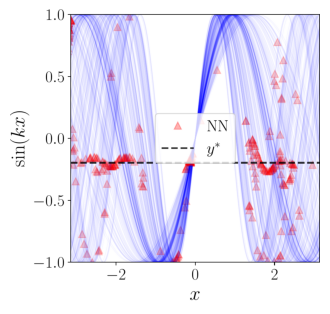

In [12]:
# create path for saving the figure
path_inv     = folder_name + '/figures/Inversion'
os.makedirs(path_inv, exist_ok = True) # warning: be careful the overwrite here
fig_name     = '/fix-y.pdf'

# save the plot
%matplotlib agg
check_sine_wave(path_inv + fig_name, X_samples, x, y_fix)
%matplotlib inline

# show figures
plt.figure(figsize=(4, 4))
im_inv1 = convert_from_path(path_inv + fig_name)
plt.imshow(im_inv1[0])
plt.axis('off')

From the above plot, we've seen most of the inverse predictions are $\color{red}far \ from$ being correct. This is due to the complexity of the current inverse problem since the latent, non-identifiable manifold is **discrete** due to the **periodicity** of sine waves. You may fine-tune the network hyper-parameters but the results may still be unacceptable.

Here we provide two architectural improvements:

##### 1. Enforcing an emulator re-constraint loss in training (see. Sec 2.4, Sec 3.1 of the paper)

For the current problem, the forward emulator $\mathscr{N}_e$ is very easy to learn, so one can enforce another MSE loss to constrain the inverse prediction
$$
\mathcal{L}_r(\boldsymbol{y}, \widehat{\widehat{\boldsymbol{y}}}) = \frac{1}{N \cdot \dim(\boldsymbol{y})} \sum_{i=1}^N \|\boldsymbol{y}_i -\widehat{\widehat{\boldsymbol{y}}}_i \|_{2}^2 \ ,
$$
where $\widehat{\widehat{\boldsymbol{y}}}_i$ is obtained by passing the inverse prediction $\widehat{\boldsymbol{v}}_i$ through the trained emulator, i.e. $\widehat{\widehat{\boldsymbol{y}}}_i = \mathscr{N}_e(\widehat{\boldsymbol{v}}_i)$.

#####  2. Expand the latent space dimensionality, i.e. increase $\dim (\boldsymbol{\mathcal{W}})$.

The original design of our $\texttt{inVAErt}$ network is to make the latent variable $\boldsymbol{w}$ have the dimensionality: $\dim(\boldsymbol{w}) = \dim(\boldsymbol{v}) - \dim(\boldsymbol{y})$ such that the ill-posedness of inverse problem is mitigated. This works for simple inverse problem like the under-determined linear system (Sec 4.1), sine waves without periodicity (Sec 4.2) and the RCR system (Sec 4.3). 

However, like the current problem, for complicated inverse processes, a larger latent space $\boldsymbol{\mathcal{W}}$ usually yields better performance. For more discussions, see Sec 2.3, Sec 4.2 of the paper.

#### Network modifications

First, we implement these two improvements into our network.

In [13]:
#----First, we need to specify a penalty coefficient for the emulator reconstraint loss Lr------#
#  Now, the three penalties are as: KL div, decoder reconstruction, emulator re-constraint 
penalty       = [1, 200, 5]          

#----Second, we provide an dimensional increment to the latent space W -------#
latent_plus = 7 # the original latent space dimensionality is 2 - 1 = 1, now we have changed it to 1 + latent_plus = 8

# Now we re-define the trainer, taking account of the "latent_plus" argument
Trainer = Training(X, Y, para_dim, train_tensor = train_tensor, train_truth_tensor = train_truth_tensor,\
									 test_tensor = test_tensor, test_truth_tensor = test_truth_tensor, latent_plus = latent_plus)

# Now we re-formulate the decoder model and skip the emulator and NF sampler, since they are trained well already
_, _, Decoder_model = Trainer.Define_Models(device, encoder_para, nf_para, vae_para, decoder_para)

Number of trainable para for encoder is:673
y is a scalar, adding one aux dimension...
Number of trainable para for NF sampler is:1352
Number of trainable para for VAE+decoder is:12498


### Re-training/testing steps of the modified decoder model

Waiting time: < 4 min


Note: remember to add arguments with respect to the emulator re-constraint loss

1: ```EN = Encoder_model```: we provide the trained emulator model here 

2: ```residual = False```: if using residual net (for dynamical systems only).

In [14]:
# training and testing step of the VAE and decoder
%matplotlib agg
Trainer.Decoder_train_test(folder_name, Decoder_model, lr_min[2], learning_rate[2], decay[2], \
                                                       nB[2], penalty, l2_decay = weight_decay[2], EN = Encoder_model, residual = False)
%matplotlib inline



---------------Start to train the variational decoder-----------------
Total number of epoches for training variational decoder is:880
VAEDecoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, inversion loss: 7.728e-01 , inversion acc : 21.789856% , KL : 3.589e+00 , Encoder_reconstraint: 1.195e+00 , current lr: 1.000e-02
Testing: inversion loss: 5.566e-01 , inversion acc : 46.316336% , KL : 5.606e+00 , Encoder_reconstraint: 1.175e+00
Training: Epoch: 200, inversion loss: 4.823e-03 , inversion acc : 99.510545% , KL : 4.409e+00 , Encoder_reconstraint: 1.483e-02 , current lr: 3.001e-03
Testing: inversion loss: 1.588e-03 , inversion acc : 99.846873% , KL : 4.491e+00 , Encoder_reconstraint: 8.899e-03
Training: Epoch: 400, inversion loss: 3.436e-03 , inversion acc : 99.652307% , KL : 4.316e+00 , Encoder_reconstraint: 5.634e-03 , current lr: 9.006e-04
Testing: inversion loss: 3.884e-04 , inversion acc : 99.962531% , KL : 4.322e+00 , Encoder_reconstraint: 2.089e-03

Now we perform the same task as above:

(-0.5, 964.5, 916.5, -0.5)

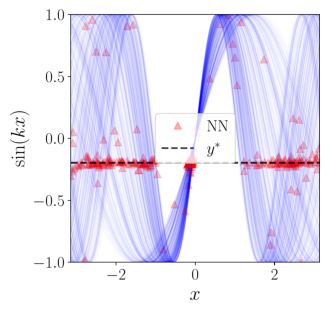

In [15]:
# sample one y^* from the trained NF (remember to use the same seed as above)
y_fix  =  NF_model.sampling(1, NF_model, seed_control= 18391)[0,0] # recall we have a concatenated Gaussian RV

# Decoding with trained N_d 
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, \
                                             seed_control = 12430 , Task = 'FixY', y_given = y_fix)
# Scaling back if needed
if Scaling == True:
	X_samples           = scaler.scale_it_back(X_samples,muX,stdX)
	y_fix               = scaler.scale_it_back(y_fix.reshape((-1,1)), muY[0].reshape((-1,1)), stdY[0].reshape((-1,1)))
    
# new figure
fig_name_new     = '/fix-y-decoder-modified.pdf'

# save the plot
%matplotlib agg
check_sine_wave(path_inv + fig_name_new, X_samples, x, y_fix)
%matplotlib inline

# show figures
plt.figure(figsize=(4, 4))
im_inv2 = convert_from_path(path_inv + fig_name_new)
plt.imshow(im_inv2[0])
plt.axis('off')

This time, we have seen most of the inverse predictions lead to a value close to our fixed $y^*$. However, there still exists a number of inversion samples that lead to erroneous predictions. These samples are referred to as $outliers$, which usually occur when the support of the learned posterior distribution $q(\boldsymbol{w}|\boldsymbol{v})$ differ too much with respect to the VAE prior, i.e. standard normal distribution.

In Sec 3.2 of the paper, we suggest a few latent space sampling method to deal with this issue. First, we show these outliers can be sufficiently removed with the PC-sampling (Predictor-Corrector) method (Alg 1, Sec 3.2.2).

#### The PC-sampling method

We perform the same task as above and turn on the ```denoise = 4``` argument in the ```inversion_sampling``` function. The number ```4``` is referred to the iteration number $R$ in the paper.

(-0.5, 964.5, 916.5, -0.5)

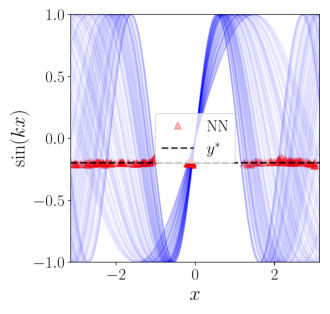

In [16]:
# sample one y^* from the trained NF (remember to use the same seed as above)
y_fix  =  NF_model.sampling(1, NF_model, seed_control= 18391)[0,0] # recall we have a concatenated Gaussian RV

# Decoding with trained N_d 
# Use denoise = R to turn on the PC-sampling method
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 12430 ,\
                                                    Task = 'FixY', y_given = y_fix, denoise = 4)
# Scaling back if needed
if Scaling == True:
	X_samples           = scaler.scale_it_back(X_samples,muX,stdX)
	y_fix               = scaler.scale_it_back(y_fix.reshape((-1,1)), muY[0].reshape((-1,1)), stdY[0].reshape((-1,1)))

# new figure
fig_name_pc     = '/fix-y-decoder-modified-PC-sampling.pdf'

# save the plot
%matplotlib agg
check_sine_wave(path_inv + fig_name_pc, X_samples, x, y_fix)
%matplotlib inline

# show figures
plt.figure(figsize=(4, 4))
im_inv3 = convert_from_path(path_inv + fig_name_pc)
plt.imshow(im_inv3[0])
plt.axis('off')

After 4 rounds, almost all the outliers are removed. Next, we plot all the inverse predictions $\widehat{\boldsymbol{v}} = [\widehat{k}, \widehat{x}]$ in the $k$-$x$ plane, which shows the structure of the non-identifiable manifold of this problem. As we expected, it consists of **discrete** components.

(-0.5, 755.5, 740.5, -0.5)

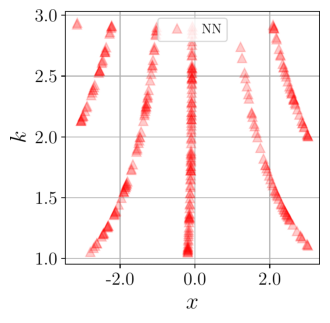

In [17]:
#Save scatter correlation plot
%matplotlib agg
scatter2D_plot(path_inv, 'k-x-PC', X_samples[:,[1,0]], '$x$', '$k$') # correlation scatter plot
%matplotlib inline

# show figures
plt.figure(figsize=(4, 5))
im_kx_pc = convert_from_path(path_inv + '/k-x-PC.pdf')
plt.imshow(im_kx_pc[0])
plt.axis('off')

#### The HD-sampling method

Next, we apply the second latent space sampling approach, the HD (High-Density) sampling method. This scheme utilizes the trained VAE encoder model $\mathscr{N}_v$ to draw latent variable samples that are associated to the training data points. For more information, please refer to Sec 3.2.3 and Alg 2 of the paper.

(-0.5, 755.5, 735.5, -0.5)

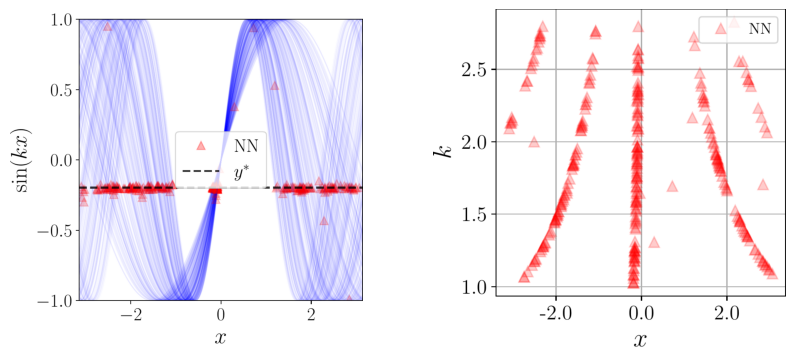

In [18]:
S = 400 # random subset size of the training data
Q = 2   # sub-sampling size of each data-dependent posterior distribution

# sample one y^* from the trained NF (remember to use the same seed as above)
y_fix  =  NF_model.sampling(1, NF_model, seed_control= 18391)[0,0] # recall we have a concatenated Gaussian RV

# Decoding with the HD-sampling method
# Note: we can also apply the PC-sampling method to denoise the samples obtained by the HD-sampling method. If so, turn on the ```denoise = xx``` option
X_samples  = Decoder_model.Decoding_HD(Decoder_model, W_size, S, Q, X[:,:para_dim], \
                                                           seed_control = 43213, y_given = y_fix) #, denoise = 4) 

# Scaling back if needed
if Scaling == True:
	X_samples           = scaler.scale_it_back(X_samples,muX,stdX)
	y_fix               = scaler.scale_it_back(y_fix.reshape((-1,1)), muY[0].reshape((-1,1)), stdY[0].reshape((-1,1)))

# new figure
fig_name_hd     = '/fix-y-decoder-modified-HD-sampling.pdf'

# save the verification plot
%matplotlib agg
check_sine_wave(path_inv + fig_name_hd, X_samples, x, y_fix)
%matplotlib inline

#Save scatter correlation plot
%matplotlib agg
scatter2D_plot(path_inv, 'k-x-HD', X_samples[:,[1,0]], '$x$', '$k$') # correlation scatter plot
%matplotlib inline

# show figures
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
im_hd_verify = convert_from_path(path_inv + fig_name_hd)
plt.imshow(im_hd_verify[0])
plt.axis('off')

plt.subplot(1, 2, 2)
im_hd_manifold = convert_from_path(path_inv + '/k-x-HD.pdf')
plt.imshow(im_hd_manifold[0])
plt.axis('off')

As discussed in Sections 3.2.3 and 4.2 of the paper, the quality of the HD-sampling method depends on the choices of hyperparameters $S$ and $Q$. Non-optimal selections of these hyperparameters can result in a significant loss of the latent space structure. In practice, relative to the entire dataset, one usually keep both $S$ and $Q$ small.

#### Sampling with normalizing flow

We can also train a new normalizing flow model $\mathscr{N}_{f, \boldsymbol{w}}$ to estimate the posterior density of the latent variable $\boldsymbol{w}$ and then sample from it. Like the HD sampling method, the training samples of $\mathscr{N}_{f, \boldsymbol{w}}$ also comes from forwarding the training dataset through the trained VAE encoder model $\mathscr{N}_v$. 

The nature of drawing samples from $\mathscr{N}_{f, \boldsymbol{w}}$ is very similar to HD sampling, hence we skip illustrating this approach here for brevity. Interested readers may refer to Sec 3.2.4 and Sec 4.2 of the paper.